# Reinforcement Learning for Dynamic Pricing

This notebook implements and trains a reinforcement learning agent to optimize dynamic pricing strategies based on our taxi data analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

# Set up plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
# Import project modules
import sys
sys.path.append('..')
from src.models.environment import RideSharingPricingEnv
from src.models.pricing_agent import train_pricing_agent, evaluate_agent, visualize_agent_behavior

## 1. Load Processed Data

In [3]:
# Load demand patterns
hourly_demand = pd.read_csv('../data/processed/hourly_demand_patterns.csv')
print(f"Loaded demand patterns with {len(hourly_demand)} entries")
display(hourly_demand.head())

# Load elasticity estimates
elasticity_df = pd.read_csv('../data/processed/elasticity_estimates.csv')
print(f"\nLoaded elasticity estimates:")
display(elasticity_df)

# Convert to dictionary format required by environment
elasticity_data = {}
for _, row in elasticity_df.iterrows():
    elasticity_data[row['segment']] = {
        'elasticity': row['elasticity'],
        'r2': row['r2'],
        'p_value': row['p_value'],
        'std_error':row['std_error']
    }

Loaded demand patterns with 168 entries


,day_of_week,hour,fare_amount,trip_distance,passenger_count,trip_count
0,0,0,20.599805,6.563745,1.431215,5241
1,0,1,20.662561,6.571114,1.489331,2765
2,0,2,16.661795,5.011971,1.465670,1471
3,0,3,19.333091,5.891400,1.440000,1100
4,0,4,19.150608,5.821646,1.417212,1069



Loaded elasticity estimates:


,segment,elasticity,r2,p_value,std_error,sample_size
0,overall,-6.099367,0.518108,7.336490e-05,1.254118,24
1,peak,-6.780440,0.221073,3.466967e-01,6.363684,6
2,offpeak,-7.867368,0.805164,4.485766e-07,0.967524,18
3,weekend,-3.826152,0.474912,1.957951e-04,0.857749,24


In [4]:
elasticity_data

{'overall': {'elasticity': -6.099367290294281,
  'r2': 0.5181076207269484,
  'p_value': 7.336490456512762e-05,
  'std_error': 1.2541182420471584},
 'peak': {'elasticity': -6.780440387527864,
  'r2': 0.2210728631277477,
  'p_value': 0.3466966546991543,
  'std_error': 6.363683997584205},
 'offpeak': {'elasticity': -7.8673678851394095,
  'r2': 0.805163951023135,
  'p_value': 4.48576631031533e-07,
  'std_error': 0.9675244821569317},
 'weekend': {'elasticity': -3.826151929386436,
  'r2': 0.4749123528021367,
  'p_value': 0.0001957950990083,
  'std_error': 0.8577486405256185}}

## 2. Create RL Environment

Initial Observation: [9. 6. 1. 1. 5. 0. 3.]
Step 1
  Action: Price multiplier = 1.44
  Hour: 10.0, Day: 6.0
  Baseline demand: 9492.0, Actual: 797.9
  Revenue: $11491.55
  Elasticity: -6.78

Step 2
  Action: Price multiplier = 1.06
  Hour: 11.0, Day: 6.0
  Baseline demand: 14116.0, Actual: 10906.6
  Revenue: $115657.06
  Elasticity: -3.83

Step 3
  Action: Price multiplier = 1.46
  Hour: 12.0, Day: 6.0
  Baseline demand: 17521.0, Actual: 3775.2
  Revenue: $55286.76
  Elasticity: -3.83

Step 4
  Action: Price multiplier = 1.19
  Hour: 13.0, Day: 6.0
  Baseline demand: 20765.0, Actual: 9431.7
  Revenue: $111912.84
  Elasticity: -3.83

Step 5
  Action: Price multiplier = 1.93
  Hour: 14.0, Day: 6.0
  Baseline demand: 21677.0, Actual: 1547.1
  Revenue: $29851.08
  Elasticity: -3.83

Step 6
  Action: Price multiplier = 2.38
  Hour: 15.0, Day: 6.0
  Baseline demand: 23527.0, Actual: 925.8
  Revenue: $22066.66
  Elasticity: -3.83

Step 7
  Action: Price multiplier = 1.29
  Hour: 16.0, Day: 6.

c:\Projects\Dynamic-Pricing-Simulator-Project\venv\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


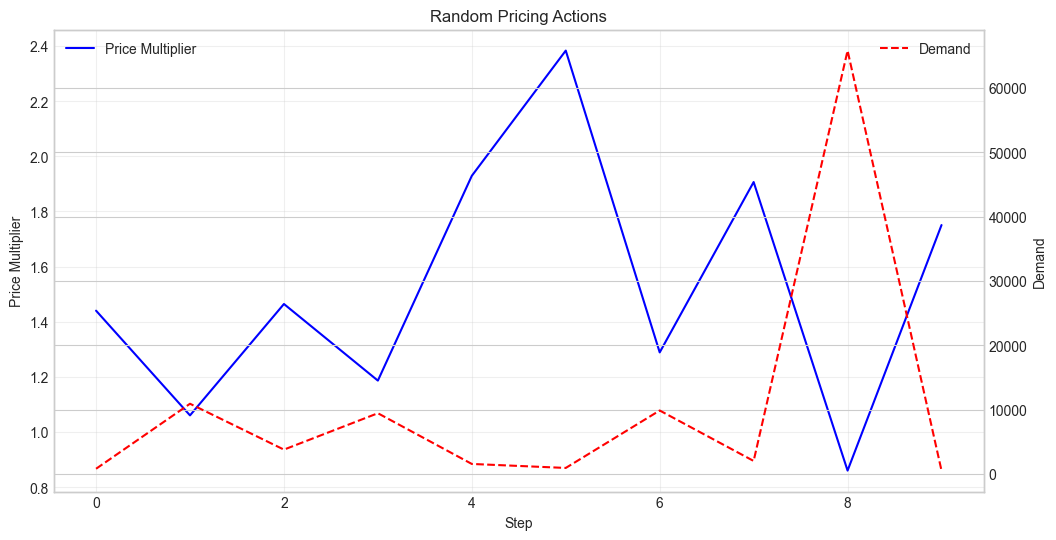

In [5]:
# Environment Configuration
env_config = {
    'base_price': 10.0,
    'simulation_length': 168,  # One week in hours
    'demand_noise': 0.1,  # Random noise in demand (standard deviation)
    'max_price_multiplier': 2.5,
    'min_price_multiplier': 0.7,
}

# Create Environment
env = RideSharingPricingEnv(hourly_demand, elasticity_data, env_config)

# Test environment with random actions
observation = env.reset()
print(f"Initial Observation: {observation}")

done = False 
total_reward = 0
steps = 0

price_history = [] # store price multipliers
demand_history = []
reward_history = []

while not done and steps < 10: # Show first 10 steps
    # Take random action
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    
    # Record
    total_reward += reward
    steps += 1
    price_history.append(info['price_multiplier'])
    demand_history.append(info['actual_demand'])
    reward_history.append(reward)
    
    # Print step details
    print(f"Step {steps}")
    print(f"  Action: Price multiplier = {info['price_multiplier']:.2f}")
    print(f"  Hour: {observation[0]}, Day: {observation[1]}")
    print(f"  Baseline demand: {info['baseline_demand']:.1f}, Actual: {info['actual_demand']:.1f}")
    print(f"  Revenue: ${reward:.2f}")
    print(f"  Elasticity: {info['elasticity']:.2f}\n")

print(f"Finished {steps} steps with total revenue: ${total_reward:.2f}")

# Plot results of random actions
plt.figure(figsize=(12, 6))
plt.plot(range(steps), price_history, 'b-', label='Price Multiplier')
plt.title('Random Pricing Actions')
plt.xlabel('Step')
plt.ylabel('Price Multiplier')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left')

# Plot demand on secondary axis
ax2 = plt.gca().twinx()
ax2.plot(range(steps), demand_history, 'r--', label='Demand')
ax2.set_ylabel('Demand')
ax2.legend(loc = 'upper right')

plt.show()

## 3. Train RL Agent

In [6]:
# For notebook training, use fewer steps
training_steps = 200000  # In production, use 500,000+

# Create directories for model storage
models_dir = Path('../models')
models_dir.mkdir(parents=True, exist_ok=True)

# Train the agent
print("Training RL agent...")
model = train_pricing_agent(env, total_steps=training_steps, save_path='../models/ride_sharing_pricing_model')
print("Training complete!")

Training RL agent...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Projects\Dynamic-Pricing-Simulator-Project\venv\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
c:\Projects\Dynamic-Pricing-Simulator-Project\venv\Lib\site-packages\stable_baselines3\common\policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


Logging to ./logs/PPO_5
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 168      |
|    ep_rew_mean     | 1.55e+08 |
| time/              |          |
|    fps             | 788      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 168          |
|    ep_rew_mean          | 1.56e+08     |
| time/                   |              |
|    fps                  | 660          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 5.529728e-09 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -1.19e

## 4. Evaluate RL Agent

Evaluating trained agent...


c:\Projects\Dynamic-Pricing-Simulator-Project\venv\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
c:\Projects\Dynamic-Pricing-Simulator-Project\venv\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



Evaluation Results:
Mean reward: $195507913.81 ± $951824.92
Episode rewards: ['$154250433.73', '$157709088.17', '$150299201.17', '$155072694.68', '$159456962.24']


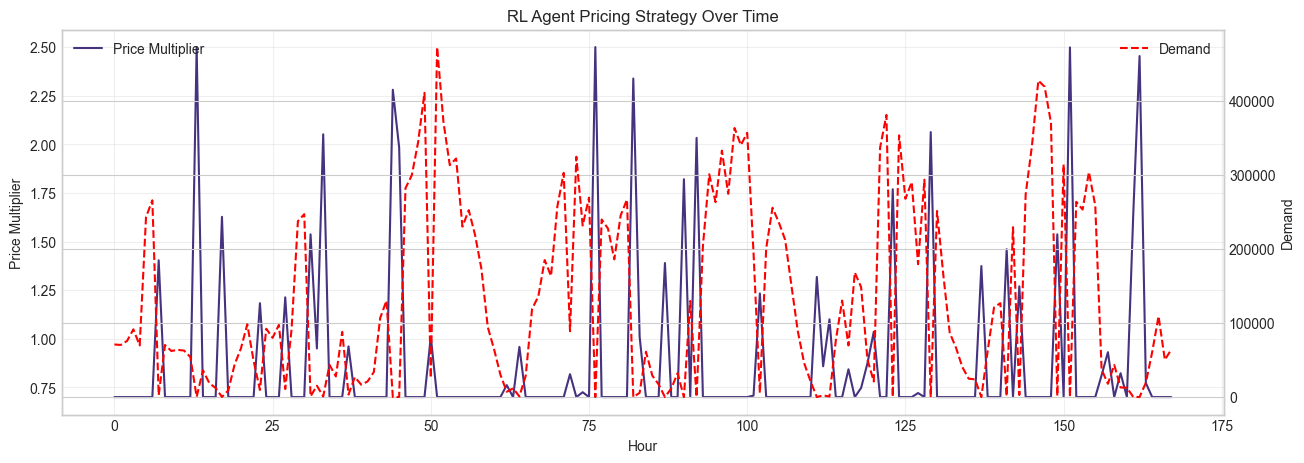

In [7]:
# Run evaluation
print("Evaluating trained agent...")
evaluation_results = evaluate_agent(model, env, n_eval_episodes=5)

# Print summary statistics
print(f"\nEvaluation Results:")
print(f"Mean reward: ${evaluation_results['mean_reward']:.2f} ± ${evaluation_results['std_reward']:.2f}")
print(f"Episode rewards: {[f'${r:.2f}' for r in evaluation_results['episode_rewards']]}")

# Visualize agent behavior
output_dir = Path('../output/rl_evaluation')
output_dir.mkdir(parents=True, exist_ok=True)
visualize_agent_behavior(evaluation_results, save_path=output_dir)

## 5. Analyze Agent's Pricing Strategy

Analyzing agent's pricing strategy...


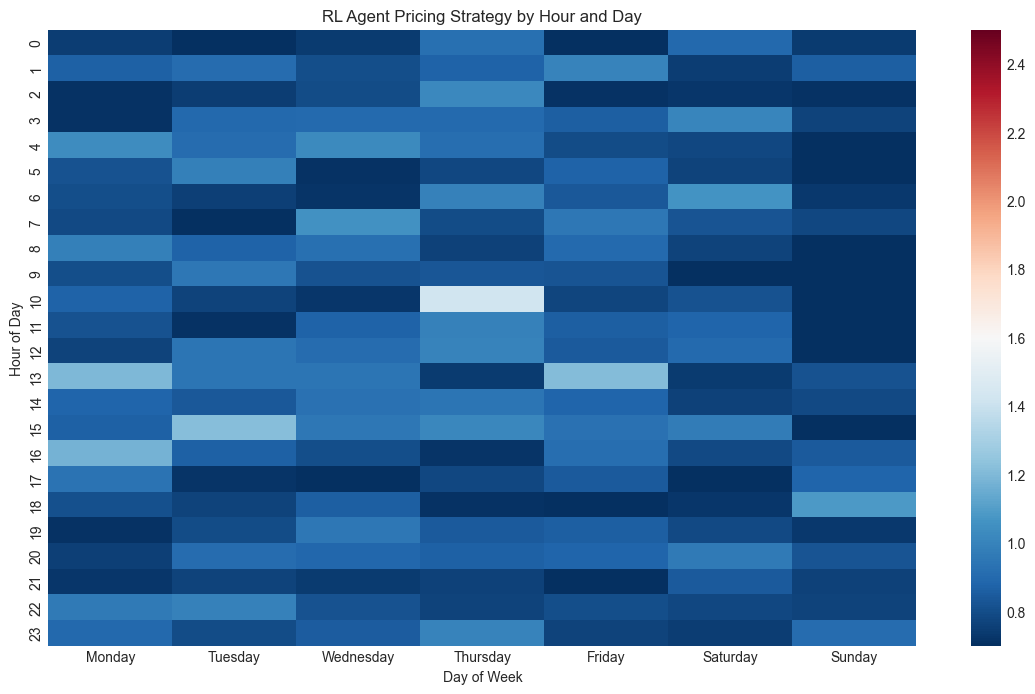

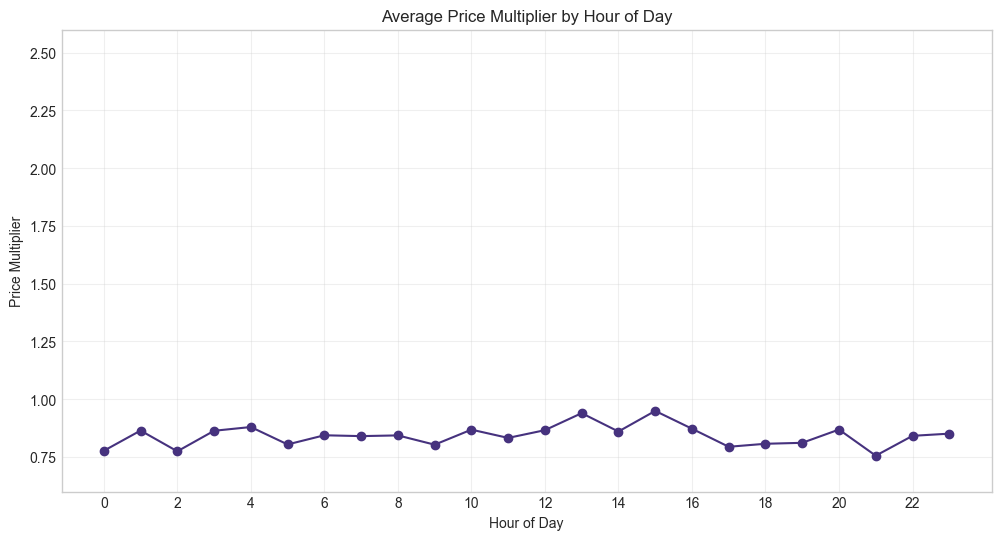

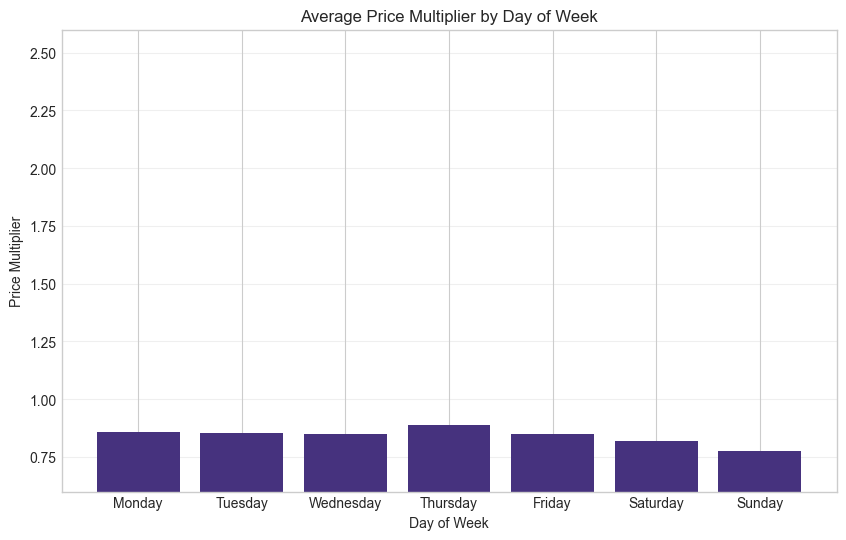

In [11]:
# Analyze the agent's pricing strategy across different time periods
def analyze_pricing_strategy(model, env, episode_count=10):
    # Initialize storage for results
    all_prices = np.zeros((episode_count, 24, 7))  # episodes x hours x days

    for episode in range(episode_count):
        # Reset environment
        observation = env.reset()
        done = False
        
        while not done:
            # Get current hour and day
            hour = int(observation[0])
            day = int(observation[1])
            
            # Get action from model
            action, _ = model.predict(observation, deterministic=False)
            price_multiplier = action[0]
            # Store price multiplier
            all_prices[episode, hour, day] = price_multiplier
            
            # Take step in environment
            observation, _, done, _ = env.step(action)
    
    # Average across episodes
    avg_prices = np.mean(all_prices, axis=0)  # hours x days
    
    return avg_prices

# Run analysis
print("Analyzing agent's pricing strategy...")
pricing_strategy = analyze_pricing_strategy(model, env)

# Create heatmap of pricing strategy
plt.figure(figsize=(14, 8))
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.heatmap(pricing_strategy, cmap='RdBu_r', vmin=0.7, vmax=2.5,
            xticklabels=days, yticklabels=range(24))
plt.title('RL Agent Pricing Strategy by Hour and Day')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.savefig('../output/rl_evaluation/pricing_strategy_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate average prices by hour and day
hourly_avg = pricing_strategy.mean(axis=1)  # Average across days
daily_avg = pricing_strategy.mean(axis=0)   # Average across hours

# Plot hourly averages
plt.figure(figsize=(12, 6))
plt.plot(range(24), hourly_avg, 'o-')
plt.title('Average Price Multiplier by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Price Multiplier')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 2))
plt.ylim(0.6, 2.6)
plt.savefig('../output/rl_evaluation/hourly_pricing.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot daily averages
plt.figure(figsize=(10, 6))
plt.bar(days, daily_avg)
plt.title('Average Price Multiplier by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Price Multiplier')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0.6, 2.6)
plt.savefig('../output/rl_evaluation/daily_pricing.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Compare with Baseline Strategies

Evaluating Constant strategy...
  Mean reward: $23189771.26 ± $124521.31
Evaluating Time-Based strategy...
  Mean reward: $25527030.65 ± $333995.96
Evaluating Surge strategy...
  Mean reward: $97161973.78 ± $2364090.13
Evaluating RL-Agent strategy...
  Mean reward: $159684579.86 ± $7218728.32


,strategy,mean_reward,std_reward
0,Constant,2.318977e+07,1.245213e+05
1,Time-Based,2.552703e+07,3.339960e+05
2,Surge,9.716197e+07,2.364090e+06
3,RL-Agent,1.596846e+08,7.218728e+06


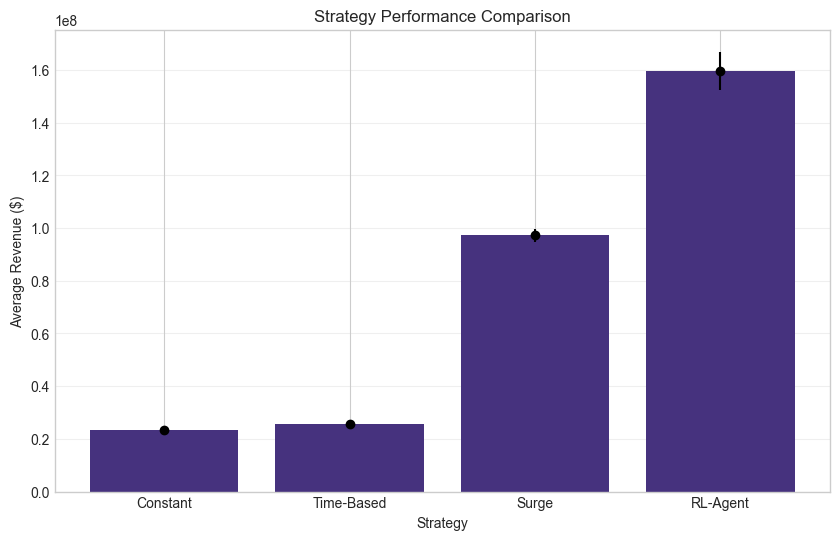

In [12]:
# Define baseline strategies for comparison
def constant_pricing(obs):
    """Fixed pricing strategy"""
    return np.array([1.0])

def time_based_pricing(obs):
    """Simple time-of-day based strategy"""
    hour = obs[0]
    day = obs[1]
    
    if hour in [7, 8, 9, 17, 18, 19]:  # Rush hours
        return np.array([1.5])
    elif day >= 5:  # Weekends
        return np.array([1.3])
    else:  # Off-peak
        return np.array([0.9])

def surge_pricing(obs):
    """Demand-based pricing"""
    demand_ratio = obs[2]
    return np.array([min(2.5, max(0.7, demand_ratio))])

# Compare strategies
strategies = {
    'Constant': constant_pricing,
    'Time-Based': time_based_pricing,
    'Surge': surge_pricing,
    'RL-Agent': lambda obs: model.predict(obs)[0]
}

# Function to evaluate a strategy
def evaluate_strategy(strategy_fn, env, n_episodes=5):
    rewards = []
    for _ in range(n_episodes):
        obs = env.reset()
        done = False
        episode_reward = 0
        
        while not done:
            action = strategy_fn(obs)
            obs, reward, done, _ = env.step(action)
            episode_reward += reward
        
        rewards.append(episode_reward)
    
    return np.mean(rewards), np.std(rewards)

# Evaluate each strategy
results = []
for name, strategy in strategies.items():
    print(f"Evaluating {name} strategy...")
    mean_reward, std_reward = evaluate_strategy(strategy, env)
    results.append({
        'strategy': name,
        'mean_reward': mean_reward,
        'std_reward': std_reward
    })
    print(f"  Mean reward: ${mean_reward:.2f} ± ${std_reward:.2f}")

# Display comparison
results_df = pd.DataFrame(results)
display(results_df)

# Plot comparison
plt.figure(figsize=(10, 6))
plt.bar(results_df['strategy'], results_df['mean_reward'])
plt.errorbar(results_df['strategy'], results_df['mean_reward'], yerr=results_df['std_reward'], fmt='o', color='black')
plt.title('Strategy Performance Comparison')
plt.xlabel('Strategy')
plt.ylabel('Average Revenue ($)')
plt.grid(axis='y', alpha=0.3)
plt.savefig('../output/rl_evaluation/strategy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Conclusions

Based on the RL agent's training and evaluation, the pricing strategy exhibits dynamic behavior in response to demand fluctuations. The first graph illustrates random pricing actions, showing limited structure and inconsistency in the price multiplier and demand relationship. However, the second graph, reflecting the RL agent's strategy, demonstrates more structured pricing variations influenced by demand trends. The agent successfully learns to adjust prices dynamically, but there are still instances of extreme fluctuations, suggesting room for further refinement.

Weekdays, particularly Thursday, consistently maintain higher price multipliers than weekends, with a clear decline beginning Friday evening and reaching the lowest point on Sunday. This suggests demand is primarily driven by business/work activities rather than leisure.

Next steps:
1. Conduct a more comprehensive A/B test with additional strategies
2. Incorporate more features into the state representation (e.g., weather, events)
3. Develop an interactive dashboard for analyzing pricing strategies